In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import scipy.signal
%matplotlib inline

In [2]:

class Image(object):
    
    def __init__(self,path):
        self.path = path
        self.bgr_image = None
        self.gray_image = None
        self.rgb_image = None
        
    def read_image(self,return_img = False):
        if not self.rgb_image:
            self.rgb_image = plt.imread(self.path)
            self.bgr_image = np.flip(self.rgb_image,axis=-1)
        
        if return_img:
            return self.bgr_image.copy()
    
    def rgb(self,return_img =False):
        if self.rgb_image is None:
            read_image()
        if return_img:
            return self.rgb_image.copy()
    
    def gray(self,return_img = False):
        self.gray_image = cv2.cvtColor(self.bgr_image, cv2.COLOR_BGR2GRAY)
        if return_img:
            return self.gray_image.copy()
    
    def Show(self,img,title='image'):
        plt.figure(figsize=[20,10])
        if len(img.shape)!=3 :
            plt.imshow(img,cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.show()
        
    def Show_all(self,image_list,title_list):
        plt.figure(figsize=[20,10])
        assert len(image_list) == len(title_list), "Houston we've got a problem"
        N = len(image_list)
        for index,(img,title) in enumerate(zip(image_list,title_list)):
            plt.subplot(1,N,index+1)
            if len(img.shape)!=3 :
                plt.imshow(img,cmap='gray')
            else:
                plt.imshow(img)
            plt.title(title)
        plt.show()
        

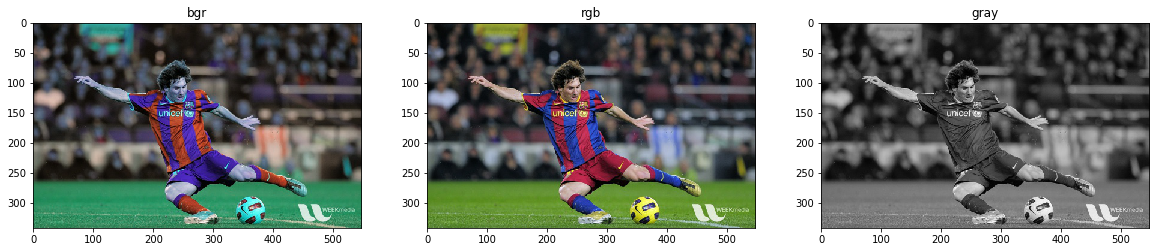

In [3]:
image = Image('./images/messi.jpg')
bgr = image.read_image(return_img=True)
rgb = image.rgb(return_img=True)
gray = image.gray(return_img=True)
image.Show_all([bgr,rgb,gray],['bgr','rgb','gray'])

#### Zero Padding
   Image padding. The padding is calculated so that the output image will have the same demensions as the 
   original image has (considering stride is always 1).
   - params:
       - image - a HxWxD image
       - k - the dimension of the kernel
   - return:
       - padded_image - an image the have been padded.

In [4]:
def zero_padding(image, k):
    p = int((k-1)/2)
    padded_image = np.zeros([2*p + image.shape[0], 2*p + image.shape[1], image.shape[2]])
    padded_image[p:-p, p:-p, :] = image
    
    return padded_image 

#### Min - Max scaling
   Min-max scaling will bring the range of pixles within an image to numbers between 0 to 1.
   - params:
       - image - a HxWxD image
   - return:
       - scaled image with pixel values between 0 to 1

In [5]:
def scale_minMax(image):
    mini,maxi = np.min(image),np.max(image)
    return (image - mini)/(maxi-mini)

#### Convolve2d
   Convolution on a given image with a given kernel.
   - params:
       - image - Gray image or RGB image
       - kernel - The kernel to be used
   - return:
      - output -  New filtered(kerneled) image 
       

In [6]:
def convolve2d(image,kernel):
    k = kernel.shape[0] # Considering kernel is NxN (filter) matrix
    kernel = np.flipud(np.fliplr(kernel)) #flip 180, equivalent to np.flip(np.flip(kernel,axis=1),axis=-1)
    image = scale_minMax(image)
    
    if len(image.shape) != 3:
        image = image.reshape(image.shape[0],image.shape[1],1)
        
    padded_image = zero_padding(image, k) 
    output = np.zeros_like(image)
    
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            for dim in range(image.shape[2]):
                output[row,col,dim] = np.sum(kernel * padded_image[row: row+k, col: col+k,dim])
                
    if image.shape[2] == 1:
        return output.reshape(image.shape[0],image.shape[1])
    else:
        return output

In [7]:
#Kernels
kernel = np.array([[0,-1,0],[-1,8,-1],[0,-1,0]])/4 # sharpen kernel
# kernel = np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])/256 # guassian-blur


## Test #2 - Gray Image

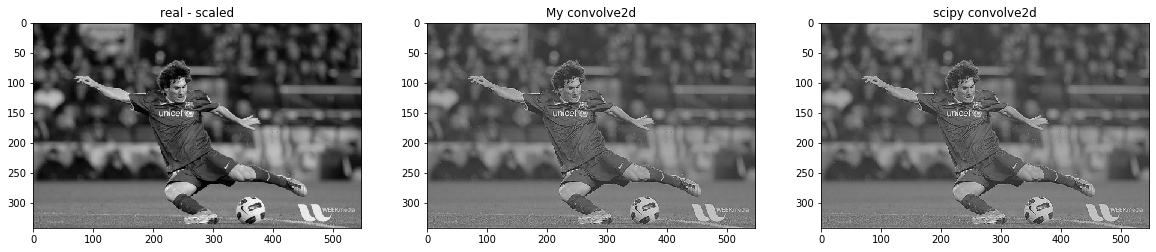

In [8]:
image_kernel = convolve2d(gray, kernel)
image_equalized = scale_minMax(gray)
image_kernel_sc = scipy.signal.convolve2d(image_equalized, kernel, 'same')
image.Show_all([image_equalized,image_kernel,image_kernel_sc],['real - scaled','My convolve2d','scipy convolve2d'])

## Test #3 - RGB image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


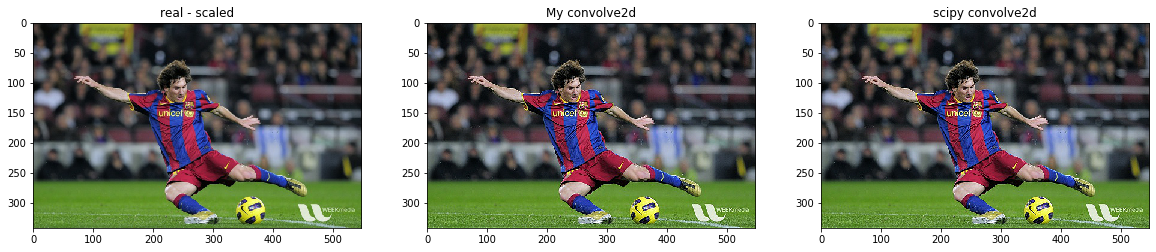

In [9]:
image_kernel = convolve2d(rgb, kernel)
image_equalized = scale_minMax(rgb)
image_kernel_sc = np.zeros_like(image_equalized)
for dim in range(rgb.shape[2]):
    image_kernel_sc[:,:,dim] = scipy.signal.convolve2d(image_equalized[:,:,dim], kernel, 'same')
image.Show_all([image_equalized,image_kernel,image_kernel_sc],['real - scaled','My convolve2d','scipy convolve2d'])

# Sobel Operator

In [10]:
ddepth = cv2.CV_64F

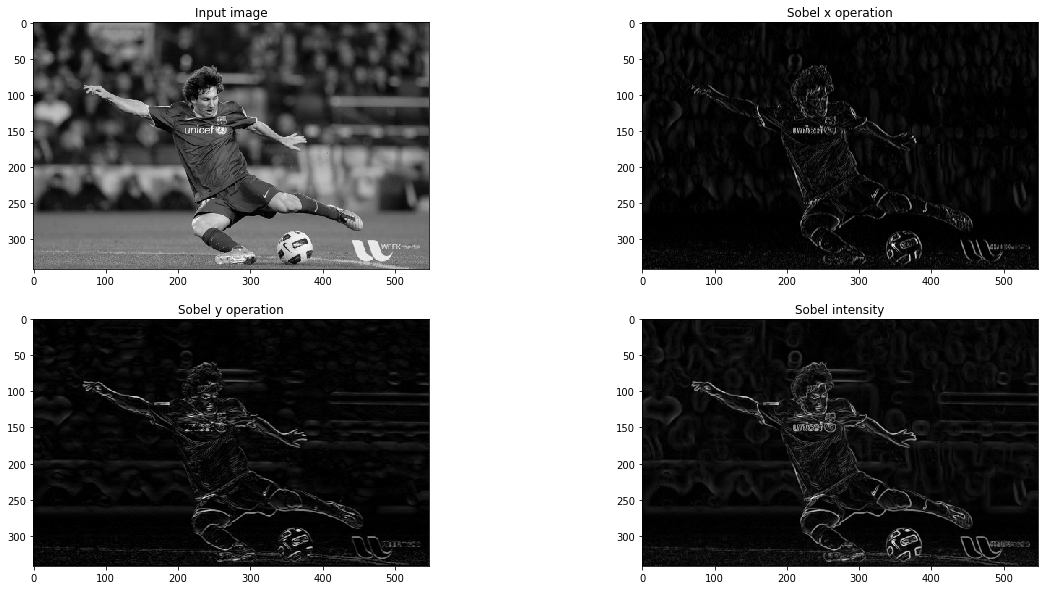

In [11]:
def sobel_edge_detection(input_image):
    if len(input_image.shape) == 3:
        input_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)
        
    input_image = scale_minMax(input_image)
    sobelx = cv2.Sobel(input_image,ddepth=ddepth,dx=1,dy=0)
    sobely = cv2.Sobel(input_image,ddepth=ddepth,dx=0,dy=1)
    sobel = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely,2.0), 1.0, 0.0))   
    
    titles = np.array(["Input image","Sobel x operation","Sobel y operation","Sobel intensity"])
    images = np.array([input_image, np.abs(sobelx),np.abs(sobely), np.abs(sobel)])
    
    rows = 2
    cols = 2
    plt.figure(figsize=[20,10])
    for index in range(len(titles)): 
        plt.subplot(rows,cols,index+1)
        plt.imshow(images[index],cmap='gray')
        plt.title(titles[index])
    
    plt.show()
        
sobel_edge_detection(gray)    

# Canny Operator
On canny operator we provide thresholds ,minValue and maxValue. Those thresholds will count pixels above the maxValue and turn the value of the pixel to 255. pixels between the extens of the thrsholds will be given some weak value and the remain pixels will be given the value zero. Then it finds the "weak values" and checks the neighbours if one of neighbor has the value 255 it will change the weak value to 255 else the value will drop to 0. The result of this operation gives us a new image with clear white edges. So the bigger the thresholds value are the less edges we will get at the output image.

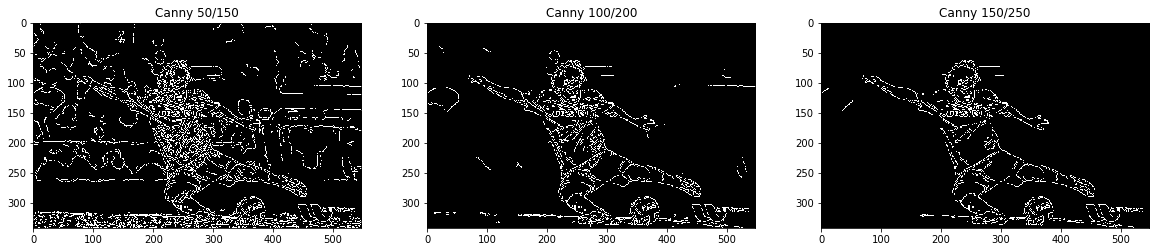

In [12]:
def canny_edge_detection(input_image):
    if len(input_image.shape) == 3:
        input_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)

    canny50_150 = cv2.Canny(input_image,50,100)
    canny100_200 = cv2.Canny(input_image,100,200)
    canny150_250 = cv2.Canny(input_image,150,250)
    
    titles = np.array(["Canny 50/150","Canny 100/200","Canny 150/250"])
    images = np.array([canny50_150, canny100_200,canny150_250])
    
    rows = 1
    cols = 3
    plt.figure(figsize=[20,10])
    for index in range(len(titles)): 
        plt.subplot(rows,cols,index+1)
        plt.imshow(images[index],cmap='gray')
        plt.title(titles[index])
    
    plt.show()
        
canny_edge_detection(rgb)    

# Find & Show Contours

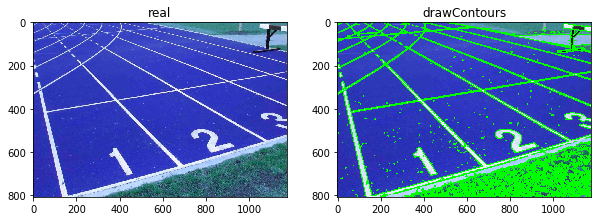

In [13]:
img = cv2.imread('./images/track.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

img_draw = np.copy(img)
edges = cv2.Canny(img_gray,100,200)
_,contours,_ = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_draw,contours,-1,(0,255,0),3)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(img)
plt.title('real')
plt.subplot(122)
plt.imshow(img_draw)
plt.title('drawContours')
plt.show()